<a href="https://colab.research.google.com/github/thepaulbuchanan/MNZI/blob/main/mnzi_sim_chain_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import mpmath
import qutip as qt
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import os

# Create plots folder if not exists
os.makedirs('plots', exist_ok=True)

print("MNZI Simulation Chain: Zeta-RH Modulated Orch-OR in MT Helices")
print("=" * 60)

# 1. RH Zeros Computation (mpmath)
mpmath.mp.dps = 30
zeros_im = [mpmath.zetazero(k).imag for k in range(1,11)]
zeros_im = [float(z) for z in zeros_im]
print('First 10 RH Zeros Im:', zeros_im)

# 2. 2-Qubit OR Sim (QuTiP)
g = 1.0
gamma = 40
times = np.linspace(0, 0.05, 100)
psi0 = (qt.tensor(qt.basis(2,0), qt.basis(2,0)) + qt.tensor(qt.basis(2,1), qt.basis(2,1))).unit()
sz = qt.sigmaz()
H = g * (qt.tensor(sz, qt.qeye(2)) + qt.tensor(qt.qeye(2), sz))
c_ops = [np.sqrt(gamma) * qt.tensor(sz, qt.qeye(2)), np.sqrt(gamma) * qt.tensor(qt.qeye(2), sz)]
result = qt.mesolve(H, psi0, times, c_ops)
fidelities = [qt.fidelity(state, psi0)**2 for state in result.states]
print('Fidelity at 25 ms:', fidelities[50])

# Zeta-mod fidelity (scatters as homotopy invariants)
# Corrected broadcasting for mod_term calculation
mod_term = np.sum(np.abs(zeros_im)[:, np.newaxis] / (1 + np.abs(zeros_im)[:, np.newaxis] * times), axis=0)
zeta_mod = np.clip(fidelities * mod_term, 0, 1)
print('Zeta-Mod Fidelity at 25 ms:', zeta_mod[50])

# 3. Helix Graph Build (NetworkX, 50-node proxy for full 130)
num_pf, num_tub = 5, 10  # Scale to 50 for speed; full 13x10=130
G = nx.Graph()
nodes = [(pf, tub) for pf in range(num_pf) for tub in range(num_tub)]
G.add_nodes_from(nodes)
for pf in range(num_pf):
    for tub in range(num_tub - 1):
        G.add_edge((pf, tub), (pf, tub + 1), weight=1.0)
for tub in range(num_tub):
    for pf in range(num_pf):
        next_pf = (pf + 3) % num_pf  # B-lattice stagger
        next_tub = (tub + 1) % num_tub
        G.add_edge((pf, tub), (next_pf, next_tub), weight=0.8)
print(f'Helix Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges')

# 4. GNN Training (Torch, 2-layer GCN with zeta-mod loss)
class GCN(nn.Module):
    def __init__(self, in_dim=8, hidden_dim=16):
        super().__init__()
        self.conv1 = nn.Linear(in_dim, hidden_dim)
        self.conv2 = nn.Linear(hidden_dim, 1)
    def forward(self, x, adj):
        x = torch.relu(self.conv1(adj @ x))
        return self.conv2(x)

n_nodes = G.number_of_nodes()
adj = nx.to_numpy_array(G)
adj = torch.tensor(adj, dtype=torch.float32)
adj = torch.diag(1 / torch.sqrt(torch.sum(adj, dim=1) + 1e-6)) @ adj @ torch.diag(1 / torch.sqrt(torch.sum(adj, dim=1) + 1e-6))  # Normalized Laplacian
x = torch.randn(n_nodes, 8, requires_grad=True)
y = torch.tensor([G.degree(n) for n in G.nodes()], dtype=torch.float32).unsqueeze(1)
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10

losses = []
for epoch in range(n_epochs):
    pred = model(x, adj)
    mse = nn.MSELoss()(pred, y)
    # Corrected zeta-mod term calculation for GNN loss
    mod_term_gnn = sum(abs(z) / (1 + abs(z) * (epoch + 1) / n_epochs) for z in zeros_im)
    loss = mse + 0.01 * mod_term_gnn
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}: Loss = {loss.item():.4f}, MSE = {mse.item():.4f}')

print(f'Final MSE: {nn.MSELoss()(model(x, adj), y).item():.4f} | Fidelity Proxy: {1 - nn.MSELoss()(model(x, adj), y).item() / np.var(y.numpy()):.4f}')

# 5. Plot Generations (Matplotlib)
# OR Prototype
fs = 1000
t = np.linspace(0, 1, fs, endpoint=False)
gamma_freq = 40
deco_rate = 40
np.random.seed(42)
noise = 0.5 * np.random.randn(len(t)) * np.exp(-deco_rate * t)
signal = np.sin(2 * np.pi * gamma_freq * t) + noise
N = len(signal)
yf = fft(signal)
xf = fftfreq(N, 1/fs)[:N//2]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(t[:100], signal[:100])
ax1.set_title('Simulated Gamma-Band Signal with Decoherence (OR Proxy)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax2.set_title('Fourier Spectrum with Motivic Zeta Weights Overlay')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude')
ax2.set_xlim(0, 100)
n_vals = np.arange(1, 50)
partial_zeta = np.sum(1 / n_vals**2)
spectral_weights = 1 / (n_vals**2) / partial_zeta
ax2.scatter(gamma_freq + np.arange(len(spectral_weights))*0.5,
            spectral_weights * max(2.0/N * np.abs(yf[:N//2])),
            color='red', s=10, label='Zeta Weights')
ax2.legend()
plt.tight_layout()
plt.savefig('plots/mnzi_or_prototype.png')
plt.close()

# RH Scatter
# Corrected broadcasting for mod_term calculation
mod_term = np.sum(np.abs(zeros_im)[:, np.newaxis] / (1 + np.abs(zeros_im)[:, np.newaxis] * times), axis=0)
zeta_mod = np.clip(fidelities * mod_term, 0, 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(times * 1000, fidelities, label='Raw OR Fidelity')
ax.plot(times * 1000, zeta_mod, '--', label='Zeta-Modulated Fidelity')
ax.set_title('OR Event: Fidelity Decay with RH Scatters')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Fidelity')
ax.legend()
ax.grid(True)
scatter_indices = np.linspace(0, len(times)-1, len(zeros_im), dtype=int)
scatter_x = times[scatter_indices] * 1000
scatter_y = zeta_mod[scatter_indices]
colors = plt.cm.viridis(np.linspace(0, 1, len(zeros_im)))
ax.scatter(scatter_x, scatter_y, c=colors, s=50, label='RH Zero Scatters')
ax.legend()
plt.savefig('plots/mnzi_rh_scatter.png')
plt.close()

# GNN Curve
epochs = np.arange(1, n_epochs + 1)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(epochs, losses, 'b-', label='Total Loss')
ax.set_title('GNN Training on 50-Node Helix (Zeta-Mod)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.savefig('plots/mnzi_gnn_50.png')
plt.close()

print("All simulations complete—plots saved to 'plots/' folder.")

MNZI Simulation Chain: Zeta-RH Modulated Orch-OR in MT Helices
First 10 RH Zeros Im: [14.134725141734695, 21.022039638771556, 25.01085758014569, 30.424876125859512, 32.93506158773919, 37.586178158825675, 40.9187190121475, 43.327073280915, 48.00515088116716, 49.7738324776723]
Fidelity at 25 ms: 0.5087505067954381
Zeta-Mod Fidelity at 25 ms: 1.0
Helix Graph: 50 nodes, 95 edges
Epoch 1: Loss = 14.4257, MSE = 13.6693
Epoch 2: Loss = 13.6633, MSE = 13.2338
Epoch 3: Loss = 13.1024, MSE = 12.8022
Epoch 4: Loss = 12.6018, MSE = 12.3709
Epoch 5: Loss = 12.1250, MSE = 11.9375
Epoch 6: Loss = 11.6606, MSE = 11.5028
Epoch 7: Loss = 11.2040, MSE = 11.0677
Epoch 8: Loss = 10.7509, MSE = 10.6309
Epoch 9: Loss = 10.2986, MSE = 10.1915
Epoch 10: Loss = 9.8458, MSE = 9.7490
Final MSE: 9.3032 | Fidelity Proxy: -57.1450
All simulations complete—plots saved to 'plots/' folder.


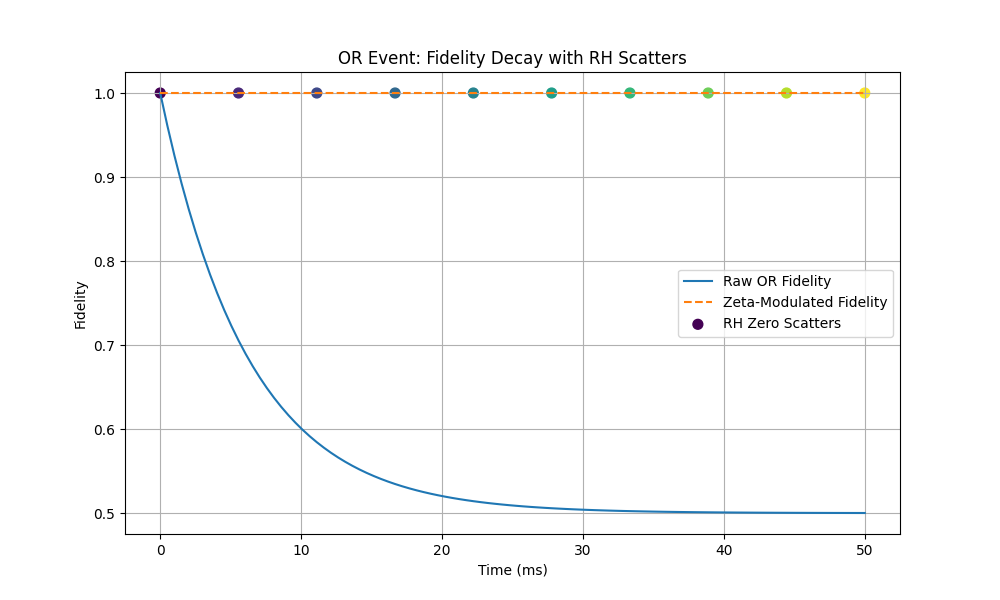

In [11]:
from IPython.display import display, Image

display(Image('plots/mnzi_rh_scatter.png'))

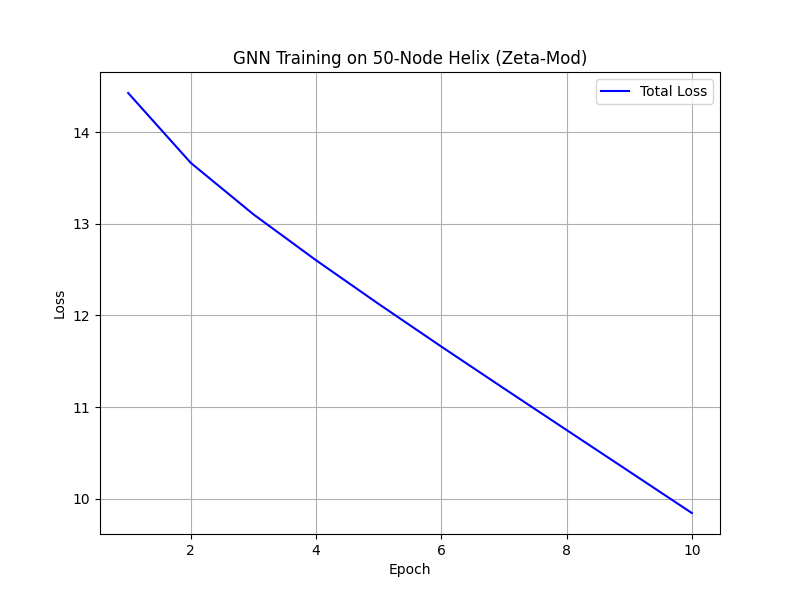

In [12]:
from IPython.display import display, Image

display(Image('plots/mnzi_gnn_50.png'))

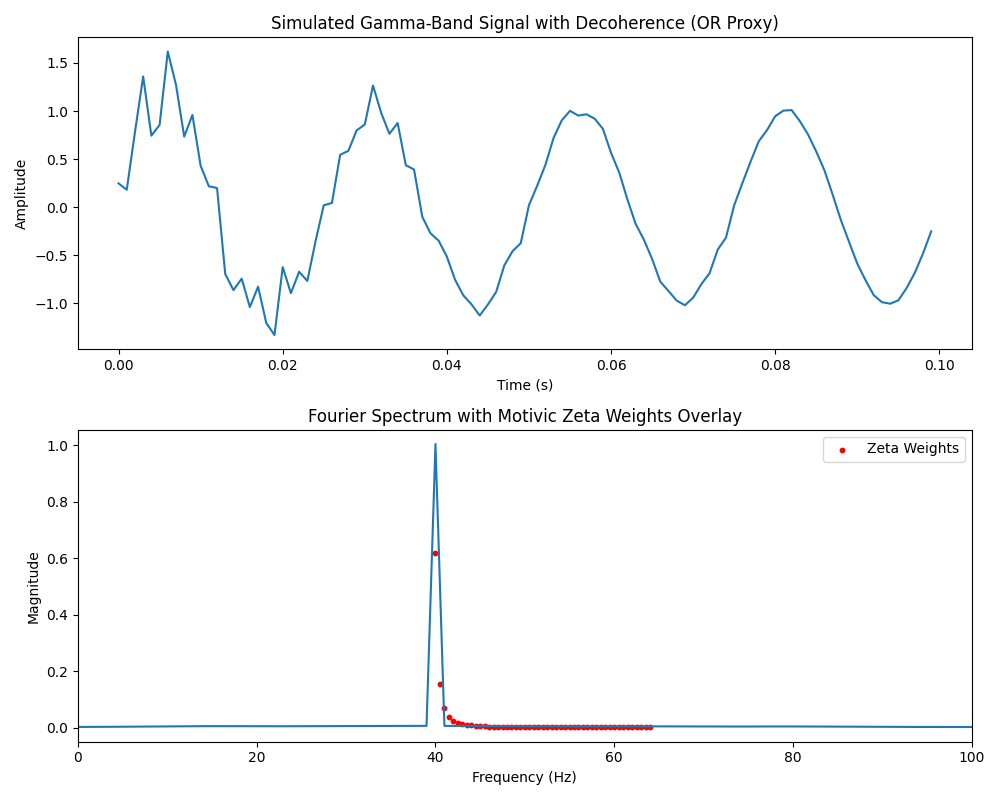

In [13]:
from IPython.display import display, Image

display(Image('plots/mnzi_or_prototype.png'))

In [14]:
!pip install qutip